In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
def group_f1_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    score = metrics.roc_auc_score(label, pred)
    return score

In [3]:
from scipy.special import softmax

def binary_cls(cls):
    if cls == 0 or cls == 1:
        return 0
    elif cls == 2 or cls == 3:
        return 1
    else:
        return None
    
def binary_pred(pred):
    pred = np.array(pred.split(','), dtype=float)
    pred_b = np.array([pred[0]+pred[1], pred[2]+pred[3]])
    pred_b = softmax(pred_b)
    return pred_b[1] # the probability to greater label

## 0. Extract SMILES for inference

In [4]:
# suppl = Chem.SDMolSupplier("./Chirality/chirbase_clean.sdf")
# mols = [x for x in suppl if x is not None]

# df_dict = {'SMILES': []}
# for mol in mols: 
#     smiles = Chem.MolToSmiles(mol)
#     df_dict['SMILES'].append(smiles)

# df = pd.DataFrame.from_dict(df_dict).drop_duplicates(['SMILES']).reset_index(drop=True)

# df.to_csv('./Chirality/chirbase_all_mol.csv', header=False, index=False)

In [5]:
# df

In [6]:
# df = pd.read_csv('./Chirality/chirbase_all_mol.csv', header=None, names=['SMILES'])

In [7]:
# df

## 1. Load the dataset

In [8]:
suppl = Chem.SDMolSupplier("./Chirality/chirbase_clean.sdf")
mols = [x for x in suppl if x is not None]

In [9]:
def convert2cls(chir, csp_category): 
    if csp_category == '1': 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2': 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

In [10]:
df_dict = {'SMILES': [], 'MB': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol)
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['Y'].append(y)

df_label = pd.DataFrame.from_dict(df_dict)

In [11]:
df_label

,SMILES,MB,K2/K1,Y
0,CCC(=O)O[C@@H](C)c1ccccc1,15,1.0100,0
1,CC(=O)O[C@@H](C)c1ccccc1,15,1.0300,0
2,O=C(O)[C@@H](Cl)c1ccccc1,15,1.0300,0
3,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,1.3100,2
4,COc1ccccc1[C@H](C)O,15,1.0400,0
...,...,...,...,...
76790,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,8,1.1843,2
76791,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,11,1.8069,2
76792,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,16,2.1600,3
76793,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,6,5.0000,3


Duplicates the compounds in each CSP (keep the larges k2/k1 in each CSP)

In [12]:
df_label = df_label.sort_values(['SMILES', 'MB', 'K2/K1'], ascending=False).drop_duplicates(['SMILES', 'MB']).sort_index()

Keep the compounds that the largest k2/k1 is in \{Class 0, Class 1\}

In [13]:
potentially_unsolved_smiles = df_label.sort_values(['SMILES', 'K2/K1'], 
                                                   ascending=False).drop_duplicates(['SMILES']).sort_index()

potentially_unsolved_smiles = potentially_unsolved_smiles[(potentially_unsolved_smiles['Y'] == 0) | 
                                                          (potentially_unsolved_smiles['Y'] == 1)]

potentially_unsolved_smiles = list(set(potentially_unsolved_smiles['SMILES'].tolist()))

Keep the compounds have more than 5 unsolved CSPs

In [14]:
# df_unsolve = df_label[df_label.SMILES.isin(potentially_unsolved_smiles)]

# df_unsolve_cnt = df_unsolve.groupby(['SMILES']).size().to_frame(name='Count').reset_index()

# df_unsolve = df_unsolve.merge(df_unsolve_cnt, on='SMILES', how='left')

# df_unsolve = df_unsolve[df_unsolve['Count'] >= 3]

In [15]:
# df_unsolve

In [16]:
# sns.countplot(x=df_unsolve['MB'])

In [17]:
# potentially_unsolved_smiles = list(set(df_unsolve['SMILES'].tolist()))

## 2. Load the prediction results

In [18]:
dfs = []
for mb in range(18): 
    dfs.append(pd.read_csv('../results_all/molnet_chirality_cls_etkdg_csp{}.csv'.format(str(mb)), 
                            sep='\t', index_col=0))
        
df_pred = pd.concat(dfs, ignore_index=True)

In [19]:
df_pred['Pred_b'] = df_pred['Pred'].apply(binary_pred)

Duplecated the SMILES and MB (keep largest probability)

In [20]:
df_pred = df_pred.sort_values(['SMILES', 'MB', 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 'MB']).sort_index()

In [21]:
df_pred

,SMILES,MB,Pred,Pred_b
0,CCC(=O)O[C@@H](C)c1ccccc1,0,"0.3889167606830597,0.5137520432472229,0.030987...",0.308885
1,CC(=O)O[C@@H](C)c1ccccc1,0,"0.16129951179027557,0.7493444085121155,0.03686...",0.305490
2,O=C(O)[C@@H](Cl)c1ccccc1,0,"0.15051311254501343,0.3496148884296417,0.45872...",0.499936
3,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,0,"0.6129103302955627,0.2749169170856476,0.102698...",0.315257
4,COc1ccccc1[C@H](C)O,0,"0.1642042100429535,0.5242459177970886,0.079424...",0.406875
...,...,...,...,...
641587,CC(C)[C@H](CO)NC(=O)COc1ccc2c(=O)c3ccccc3oc2c1,17,"0.1206110492348671,0.00039688986726105213,0.87...",0.680916
641588,C[C@H](CO)NC(=O)COc1ccc2c(=O)c3ccccc3oc2c1,17,"0.05070577934384346,0.0003198385238647461,0.94...",0.710528
641589,C[C@@H](O)CNC(=O)COc1ccc2c(=O)c3ccccc3oc2c1,17,"0.2399488240480423,0.008412951603531837,0.7515...",0.623229
641590,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,17,"0.10954707860946655,0.004006172996014357,0.495...",0.684146


## 3. Plot the predicted solvable CSP count

Enantioselective CSPs count in labels

In [22]:
df_label_solve = df_label[(df_label['Y'] == 2) | (df_label['Y'] == 3)]
df_label_solve_cnt = df_label_solve.groupby(['SMILES']).size().to_frame(name='Count').reset_index()

smiles_list = list(set(df_label['SMILES'].tolist()))
solve_smiles_list = list(set(df_label_solve['SMILES'].tolist()))
unsolve_smiles_list = [s for s in smiles_list if s not in solve_smiles_list]
df_label_unsolve_cnt = pd.DataFrame.from_dict({'SMILES': unsolve_smiles_list, 'Count': [0]*len(unsolve_smiles_list)})

df_label_cnt = pd.concat([df_label_solve_cnt, df_label_unsolve_cnt])

In [23]:
df_label_cnt

,SMILES,Count
0,B[PH](C)(CCO)c1ccccc1,1
1,B[PH](C)(c1ccccc1)c1cccc(OC)c1,1
2,B[PH](C)(c1ccccc1)c1ccccc1C(=O)OC(C)(C)C,1
3,B[PH](C)(c1ccccc1)c1ccccc1C(=O)Oc1c(C(C)C)cccc...,1
4,B[PH](C)(c1ccccc1)c1ccccc1C(=O)Oc1c(C)cccc1C,1
...,...,...
7990,Cc1ccc(S(=O)(=O)N[C@H]2COc3ccccc3C2=O)cc1,0
7991,COc1ccc(CO[C@H](C(=O)c2ccccc2)c2ccccc2)cc1,0
7992,O=C(Cc1ccc([N+](=O)[O-])cc1)[C@H](CO)Cc1ccccc1,0
7993,CC#CCN1C(=O)OC[C@@H]1CO,0


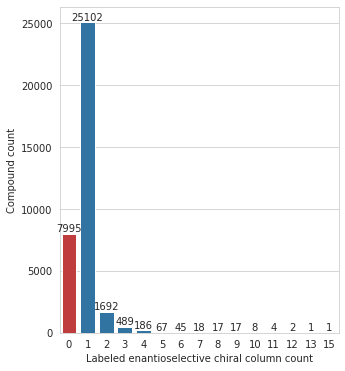

In [67]:
fig, ax = plt.subplots(figsize=(5, 6))

sns.countplot(data=df_label_cnt, x="Count", ax=ax, palette=['tab:red']+['tab:blue']*15)
# ax.set_yscale('log')
for label in ax.containers:
    ax.bar_label(label)
    
ax.set(xlabel='Labeled enantioselective chiral column count', ylabel='Compound count')

plt.savefig('./label_cnt.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./label_cnt.png', dpi=600, bbox_inches='tight')
plt.show()

Enantioselective CSPs count in predictions (exclude the labeled CSPs for each compounds)

In [32]:
df_label['MB'] = df_label['MB'].astype(int)
df_pred['MB'] = df_pred['MB'].astype(int)

df_pred_unlabeled = df_pred.merge(df_label, on=['SMILES', 'MB'], how='left')
df_pred_unlabeled = df_pred_unlabeled[df_pred_unlabeled['Y'].isna()]

df_pred_solve = df_pred_unlabeled[df_pred_unlabeled['Pred_b'] > 0.5]
df_pred_solve_cnt = df_pred_solve.groupby(['SMILES']).size().to_frame(name='Count').reset_index()

smiles_list = list(set(df_pred['SMILES'].tolist()))
solve_smiles_list = list(set(df_pred_solve['SMILES'].tolist()))
unsolve_smiles_list = [s for s in smiles_list if s not in solve_smiles_list]
df_pred_unsolve_cnt = pd.DataFrame.from_dict({'SMILES': unsolve_smiles_list, 'Count': [0]*len(unsolve_smiles_list)})

df_pred_cnt_label = pd.concat([df_pred_solve_cnt, df_pred_unsolve_cnt])

df_pred_cnt_label['Label'] = df_pred_cnt_label['SMILES'].apply(lambda x: 'potentially unsolved' \
                                                                if x in potentially_unsolved_smiles \
                                                                else 'solved')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


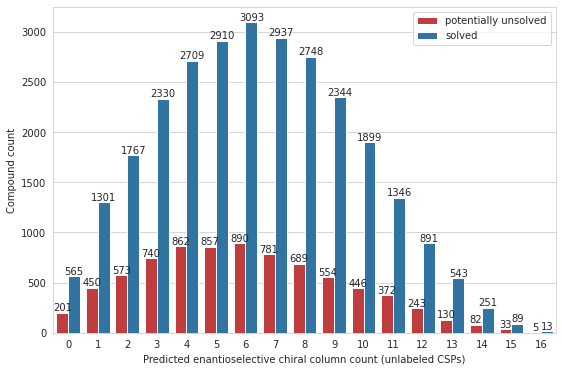

In [63]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.countplot(data=df_pred_cnt_label, x="Count", hue='Label', ax=ax,
             hue_order=['potentially unsolved', 'solved'],
             palette=['tab:red', 'tab:blue'])
# ax.set_yscale('log')
plt.legend(loc='upper right')
for label in ax.containers:
    ax.bar_label(label)

ax.set(xlabel='Predicted enantioselective chiral column count (unlabeled CSPs)', ylabel='Compound count')

plt.savefig('./pred_cnt_unlabel.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./pred_cnt_unlabel.png', dpi=600, bbox_inches='tight')
plt.show()

In [33]:
df_label['MB'] = df_label['MB'].astype(int)
df_pred['MB'] = df_pred['MB'].astype(int)

df_pred_labeled = df_pred.merge(df_label, on=['SMILES', 'MB'], how='left')
df_pred_labeled = df_pred_labeled[~df_pred_labeled['Y'].isna()]

df_pred_solve = df_pred_labeled[df_pred_labeled['Pred_b'] > 0.5]
df_pred_solve_cnt = df_pred_solve.groupby(['SMILES']).size().to_frame(name='Count').reset_index()

smiles_list = list(set(df_pred['SMILES'].tolist()))
solve_smiles_list = list(set(df_pred_solve['SMILES'].tolist()))
unsolve_smiles_list = [s for s in smiles_list if s not in solve_smiles_list]
df_pred_unsolve_cnt = pd.DataFrame.from_dict({'SMILES': unsolve_smiles_list, 'Count': [0]*len(unsolve_smiles_list)})

df_pred_cnt_unlabeled = pd.concat([df_pred_solve_cnt, df_pred_unsolve_cnt])

df_pred_cnt_unlabeled['Label'] = df_pred_cnt_unlabeled['SMILES'].apply(lambda x: 'potentially unsolved' \
                                                                        if x in potentially_unsolved_smiles \
                                                                        else 'solved')

Enantioselective CSPs count in predictions (the labeled CSPs for each compounds)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


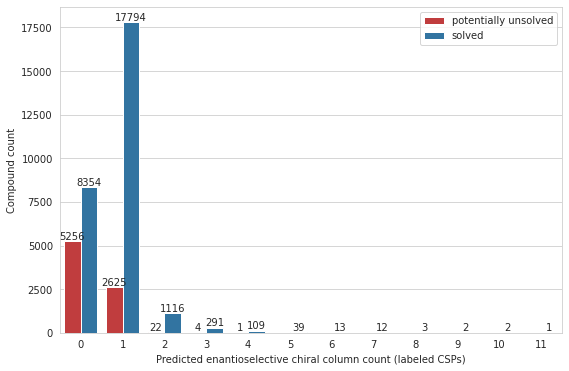

In [64]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.countplot(data=df_pred_cnt_unlabeled, x="Count", hue='Label', ax=ax, 
              hue_order=['potentially unsolved', 'solved'],
             palette=['tab:red', 'tab:blue'])
# ax.set_yscale('log')
plt.legend(loc='upper right')
for label in ax.containers:
    ax.bar_label(label)

ax.set(xlabel='Predicted enantioselective chiral column count (labeled CSPs)', ylabel='Compound count')

plt.savefig('./pred_cnt_label.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./pred_cnt_label.png', dpi=600, bbox_inches='tight')
plt.show()

In [60]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 2, 2]}, sharey=True)
# fig.subplots_adjust(hspace=0.02, wspace=0.02)



# sns.countplot(data=df_label_cnt, x="Count", ax=axs[0], palette=['tab:red']+['tab:blue']*15)
# axs[0].set_yscale('log')
# for label in axs[0].containers:
#     axs[0].bar_label(label)
# axs[0].set(xlabel='Labeled enantioselective chiral column count', ylabel='Compound count')



# sns.countplot(data=df_pred_cnt_unlabeled, x="Count", hue='Label', ax=axs[1], 
#               hue_order=['potentially unsolved', 'solved'],
#              palette=['tab:red', 'tab:blue'])
# axs[1].legend(loc='upper right')
# axs[1].yaxis.label.set_visible(False)
# for label in axs[1].containers:
#     axs[1].bar_label(label)
# axs[1].set(xlabel='Predicted enantioselective chiral column count (labeled CSPs)', ylabel='Compound count')



# sns.countplot(data=df_pred_cnt_label, x="Count", hue='Label', ax=axs[2],
#              hue_order=['potentially unsolved', 'solved'],
#              palette=['tab:red', 'tab:blue'])
# axs[2].legend(loc='upper right')
# axs[2].yaxis.label.set_visible(False)
# for label in axs[2].containers:
#     axs[2].bar_label(label)
# axs[2].set(xlabel='Predicted enantioselective chiral column count (unlabeled CSPs)', ylabel='Compound count')



# # plt.savefig('./unsolved_compound.eps', dpi=600, bbox_inches='tight', format='eps')
# # plt.savefig('./unsolved_compound.png', dpi=600, bbox_inches='tight')
# plt.show()